In [1]:
import numpy as np
import os
import scipy.io
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import pandas as pd
import json
from tqdm import tqdm
from glob import glob

In [2]:
DEVKIT_PATH = 'E:/ILSVRC2012_devkit_t12/ILSVRC2012_devkit_t12'
TRAIN_IMAGES_PATH = 'E:/ILSVRC2012_img_train'
TRAIN_ANNOTATIONS_PATH = 'E:/ILSVRC2012_bbox_train_v2'
VAL_IMAGES_PATH = 'E:/ILSVRC2012_img_val'

# Load label meanings

In [3]:
meta = scipy.io.loadmat(os.path.join(DEVKIT_PATH, 'data/meta.mat'))
meta = meta['synsets'][:, 0]

In [4]:
label_metadata = []
for m in meta:
    label, wordnet_id, human_readable, _, _, _, _, num_train_images = m

    label = label[0, 0]
    wordnet_id = wordnet_id[0]
    human_readable = human_readable[0]
    num_train_images = num_train_images[0, 0]
    
    if label <= 1000:
        label_metadata.append((label, wordnet_id, human_readable, num_train_images))

columns = ['integer_label', 'wordnet_id', 'human_readable', 'num_train_images']
label_metadata = pd.DataFrame(label_metadata, columns=columns)

In [5]:
wordnet_decoder = {T.wordnet_id: T.human_readable for T in label_metadata.itertuples()}
id_decoder = {T.integer_label: T.wordnet_id for T in label_metadata.itertuples()}

In [6]:
print('number of training examples:', label_metadata.num_train_images.sum())

number of training examples: 1281167


# Parse bounding boxes

In [7]:
def process_xml_annotation(xml_file):
    """Process a single XML file containing bounding boxes."""

    tree = ET.parse(xml_file)
    root = tree.getroot()
    width = float(root.find('size').find('width').text)
    height = float(root.find('size').find('height').text)
    filename = root.find('filename').text

    boxes = []
    for child in tree.getroot():
        if child.tag == 'object':
            bbox = child.find('bndbox')

            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)            
            class_label = child.find('name').text

            xmin = xmin / width
            xmax = xmax / width
            ymin = ymin / height
            ymax = ymax / height

            xmin = min(xmin, xmax)
            xmax = max(xmin, xmax)
            xmin = min(max(xmin, 0.0), 1.0)
            xmax = min(max(xmax, 0.0), 1.0)

            ymin = min(ymin, ymax)
            ymax = max(ymin, ymax)
            ymin = min(max(ymin, 0.0), 1.0)
            ymax = min(max(ymax, 0.0), 1.0)

            boxes.append((xmin, ymin, xmax, ymax, class_label))

    return boxes, filename

In [8]:
xml_files = glob(os.path.join(TRAIN_ANNOTATIONS_PATH, '*/*.xml'))
print('number of annotations:', len(xml_files))

number of annotations: 544546


In [9]:
all_wordnet_ids = list(wordnet_decoder.keys())

skipped_boxes = 0
skipped_files = 0
saved_boxes = 0
saved_files = 0

annotations = []
weird_files = []
for path in tqdm(xml_files):
    
    folder = os.path.basename(os.path.dirname(path))
    assert folder in all_wordnet_ids

    boxes, filename = process_xml_annotation(path)
    assert len(boxes) > 0
    
    image_filename = os.path.splitext(os.path.basename(path))[0]
    if filename != image_filename:
        weird_files.append(path)

    found_box = False
    for box in boxes:
        xmin, ymin, xmax, ymax, label = box

        if label != folder:
            skipped_boxes += 1
            weird_files.append(path)
            continue

        if (xmin >= xmax) or (ymin >= ymax):
            skipped_boxes += 1
            weird_files.append(path)
            continue
        
        annotations.append((image_filename, xmin, ymin, xmax, ymax))

        saved_boxes += 1
        found_box = True

    if found_box:
        saved_files += 1
    else:
        skipped_files += 1

100%|█████████████████████████████████████████████████████████████████████████| 544546/544546 [27:49<00:00, 326.14it/s]


In [10]:
print(saved_files, saved_boxes, skipped_files, skipped_boxes)

523966 593173 20580 22126


In [11]:
annotations = pd.DataFrame(annotations, columns=['just_name', 'xmin', 'ymin', 'xmax', 'ymax'])

# Collect paths to training examples

In [12]:
# collect all paths to images

training = []
for path, subdirs, files in tqdm(os.walk(TRAIN_IMAGES_PATH)):
    for name in files:
        training.append(os.path.join(path, name))
        
training = pd.DataFrame(training, columns=['path'])
training['wordnet_id'] = training.path.apply(lambda x: x.split('/')[-2])
training['just_name'] = training.path.apply(lambda x: x.split('/')[-1][:-5])

# unique file extensions
training.path.apply(lambda x: x.split('.')[-1]).unique()

1001it [01:39, 10.03it/s]


array(['JPEG'], dtype=object)

In [13]:
assert training.wordnet_id.isin(all_wordnet_ids).all()
assert annotations.just_name.isin(training.just_name).all()

AssertionError: 

In [14]:
print('number of training examples:', len(training))

number of training examples: 1281167


# Show some training images

In [15]:
i = np.random.randint(0, len(training))
p = training.loc[i].path
print(wordnet_decoder[training.loc[i].wordnet_id])
Image.open(p)

KeyError: 'E:'

In [16]:
def draw_boxes(image, boxes):
    
    width, height = image.size
    scaler = np.array([width, height, width, height])
    boxes = boxes*scaler

    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy, 'RGBA')

    for box in boxes:
        xmin, ymin, xmax, ymax = box

        fill = (255, 0, 0, 75)
        outline = 'black'

        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )

    return image_copy

pitcher, ewer


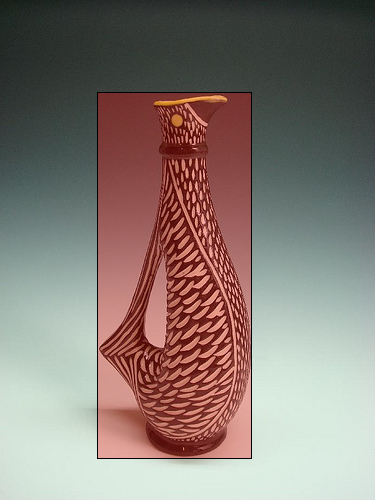

In [17]:
i = np.random.randint(0, len(annotations))
just_name = annotations.loc[i, 'just_name']
wordnet_id = just_name.split('_')[0]

image = Image.open(os.path.join(TRAIN_IMAGES_PATH, wordnet_id, just_name + '.JPEG'))
boxes = annotations.loc[annotations['just_name'] == just_name, ['xmin', 'ymin', 'xmax', 'ymax']].values

print(wordnet_decoder[wordnet_id])
draw_boxes(image, boxes)

# Get labels for validation images

In [18]:
# get labels for validation images

with open(os.path.join(DEVKIT_PATH, 'data/ILSVRC2012_validation_ground_truth.txt')) as f:
    content = f.readlines()

content = [int(s.strip()) for s in content]
content = [id_decoder[i] for i in content]
len(content)

50000

In [19]:
validation = []
for name in os.listdir(VAL_IMAGES_PATH):
    number = name.split('_')[-1].split('.')[0]
    number = int(number.lstrip())
    validation.append((os.path.join(VAL_IMAGES_PATH, name), number))

validation = sorted(validation, key=lambda x: x[1])
validation = [p for p, _ in validation]

validation = pd.DataFrame(validation, columns=['path'])
validation['wordnet_id'] = content

# Show some validation images

cardoon


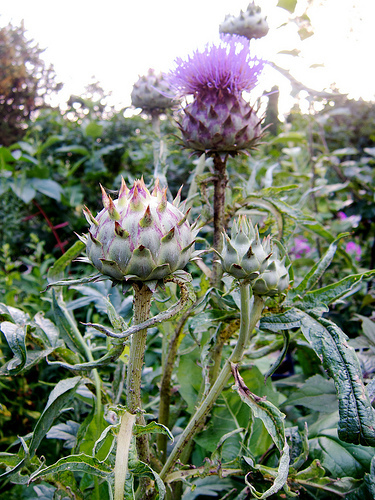

In [20]:
i = np.random.randint(0, len(validation))
p = validation.loc[i].path
print(wordnet_decoder[validation.loc[i].wordnet_id])
Image.open(p)

# Save

In [21]:
training.to_csv('training_metadata.csv', index=False)
validation.to_csv('validation_metadata.csv', index=False)

In [22]:
boxes = {}
for T in annotations.itertuples():
    if T.just_name in boxes:
        boxes[T.just_name] += [(T.xmin, T.ymin, T.xmax, T.ymax)]
    else:
        boxes[T.just_name] = [(T.xmin, T.ymin, T.xmax, T.ymax)]
        
for name in boxes:
    boxes[name] = np.array(boxes[name], dtype='float32')

In [23]:
np.save('boxes.npy', boxes)

In [24]:
with open('wordnet_decoder.json', 'w') as f:
    json.dump(wordnet_decoder, f, indent=0)

In [25]:
# this will be used when training
encoding = {n: i - 1 for i, n in id_decoder.items()}
# integer labels are from 0 to 999

In [26]:
with open('integer_encoding.json', 'w') as f:
    json.dump(encoding, f, indent=0)